# Python Notebook for project - Evaluating user abandonment due to page performance
## Bayesian Statistics - Fall 2021 ISYE6420
### StudentID: oansari3 (Omer Ansari)
Date: 12/5/2021


-----

- the write up is [here](https://docs.google.com/document/d/1TNwxpCp792jYkmwRaYQHc5_RueoHHVfpy-293X8gXeE/edit#)
- this notebook contains the computation done for the writeup.
- The best way to run this notebook is to upload to Google Colab. and "Run All"

In [9]:
import pandas as pd

url="https://drive.google.com/file/d/1fpV8b0qPH1HlnTr6Nru6k1XDBKb7nIqZ/view?usp=sharing"
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
page_data = pd.read_csv(url2)

# cleaning out the commas and converting to numeric
page_data = page_data.replace(',','', regex=True)
page_data['Bounces (1000s)'] = pd.to_numeric(page_data['Bounces (1000s)'])
                                             
page_data = page_data.rename(columns={"Avg First Contentful Paint(s)": "fcp", "Bounces (1000s)": "bounces"})

In [10]:
%%capture
!pip install bambi

### ****Important note**** 
restart the runtime after installing bambi.

In [12]:
import pymc3 as pm
import arviz as az
import bambi


model = bambi.Model("bounces ~ fcp", page_data)
fitted = model.fit(draws=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [bounces_sigma, Intercept, fcp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


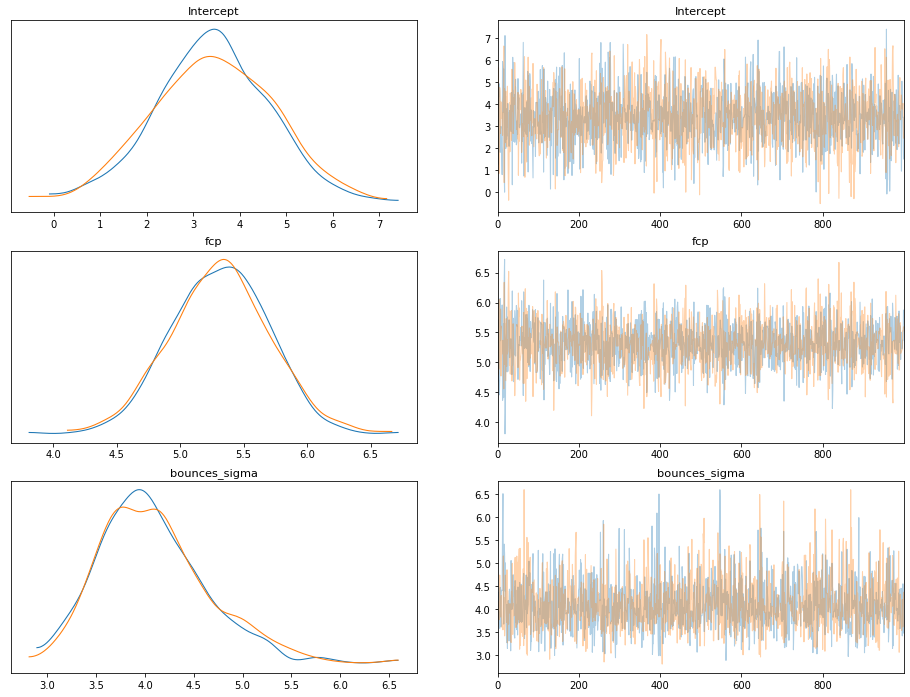

In [14]:
az.plot_trace(fitted, compact=False,figsize=(16,12));

In [15]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.418,1.288,0.879,5.761,0.026,0.019,2506.0,1428.0,1.0
fcp,5.313,0.384,4.632,6.034,0.008,0.005,2474.0,1451.0,1.0
bounces_sigma,4.097,0.574,3.119,5.209,0.013,0.009,2088.0,1539.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f377bead1d0>,
      dtype=object)

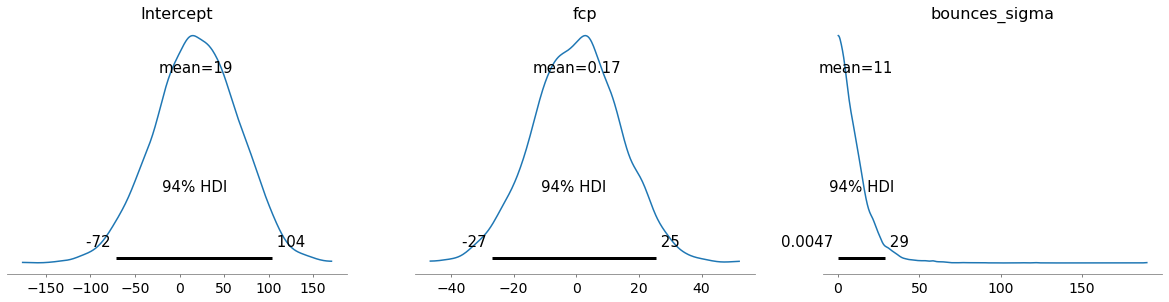

In [16]:
model.plot_priors()

#Plotting the actual vs predicted data



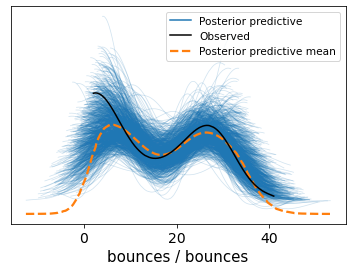

In [18]:
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

az.plot_ppc(fitted);

The blue lines represent the posterior predictive distribution estimates, and the black line represents the observed data (which is # of bounces/day in 1000s). Our posterior predictions seems to perform an adequately good job representing the observed data in all regions except closer to 0, where the observed data and posterior estimates diverge. This can be explained as follows. Low FCP values necessarily do not mean we will have lower # of bounces. The average is of the actual # of bounces is higher than the mean, which implies the users were bouncing off the page not because page performance issues (obviously, since FCP was low), but because of other intrinsic reasons (stale content, or inaccurate social advertising)


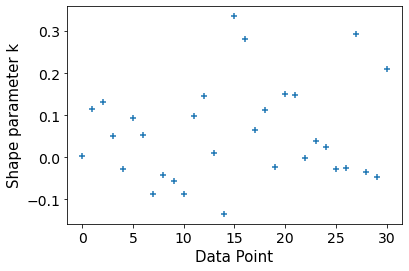

In [19]:
# compute pointwise LOO
loo = az.loo(fitted, pointwise=True)



# plot kappa values
az.plot_khat(loo.pareto_k);

Note. the kappa values are interpreted as, the higher the better, as per this [link](https://towardsdatascience.com/interpretation-of-kappa-values-2acd1ca7b18f)

Kappa value interpretation Landis & Koch (1977):
- <0 No agreement
- 0 — .20 Slight
- .21 — .40 Fair
- .41 — .60 Moderate
- .61 — .80 Substantial
- .81–1.0 Perfect

Our range of k values is around 0-0.2.

##future todo#

- create fresh data using bambi.predict() [link](https://bambinos.github.io/bambi/main/notebooks/logistic_regression.html#Spaghetti-plot-of-model-predictions)
- measure accuracy by extracting actual vs predicted using arvis.r2_score [link](https://arviz-devs.github.io/arviz/api/generated/arviz.r2_score.html)